# **Introductions**

Take the data from New York State Official SVI (2022, the latest) from the official site: https://svi.cdc.gov/dataDownloads/data-download.html

1. Downloaded the data and cleaned it to only include NY city svi scores.

2. Added a new race column, White (Non-Hispanic), to the set and check how all the racial composites correlate with the SVI scores.

3. Picked 11 evictions hotspot neighborhoods and 5 eviction coldspot neighborhoods and see how the racial composites correlate with these particular neighborhoods' evictions. 

4. Conducted a comprehensive correlation tests on all the relevant SVI metrics and how they influence each other. 

5. Saved the reduced and cleaned SVI dataset to cloud for later merge and analysis. 

So far, due to the fact that SVI dataset was directly from the government owned website and was collected, calculated, and put together by data scientists originally, it is the most clean and organized dataset to work with. 


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [47]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# data source:
# https://svi.cdc.gov/dataDownloads/data-download.html
# 2022, latest
file_path1 = '/content/drive/My Drive/X999/NewYork_ZCTA.csv'

In [4]:
svi_df = pd.read_csv(file_path1)

In [5]:
list(svi_df.columns)

['ST',
 'STATE',
 'ST_ABBR',
 'FIPS',
 'LOCATION',
 'AREA_SQMI',
 'E_TOTPOP',
 'M_TOTPOP',
 'E_HU',
 'M_HU',
 'E_HH',
 'M_HH',
 'E_POV150',
 'M_POV150',
 'E_UNEMP',
 'M_UNEMP',
 'E_HBURD',
 'M_HBURD',
 'E_NOHSDP',
 'M_NOHSDP',
 'E_UNINSUR',
 'M_UNINSUR',
 'E_AGE65',
 'M_AGE65',
 'E_AGE17',
 'M_AGE17',
 'E_DISABL',
 'M_DISABL',
 'E_SNGPNT',
 'M_SNGPNT',
 'E_LIMENG',
 'M_LIMENG',
 'E_MINRTY',
 'M_MINRTY',
 'E_MUNIT',
 'M_MUNIT',
 'E_MOBILE',
 'M_MOBILE',
 'E_CROWD',
 'M_CROWD',
 'E_NOVEH',
 'M_NOVEH',
 'E_GROUPQ',
 'M_GROUPQ',
 'EP_POV150',
 'MP_POV150',
 'EP_UNEMP',
 'MP_UNEMP',
 'EP_HBURD',
 'MP_HBURD',
 'EP_NOHSDP',
 'MP_NOHSDP',
 'EP_UNINSUR',
 'MP_UNINSUR',
 'EP_AGE65',
 'MP_AGE65',
 'EP_AGE17',
 'MP_AGE17',
 'EP_DISABL',
 'MP_DISABL',
 'EP_SNGPNT',
 'MP_SNGPNT',
 'EP_LIMENG',
 'MP_LIMENG',
 'EP_MINRTY',
 'MP_MINRTY',
 'EP_MUNIT',
 'MP_MUNIT',
 'EP_MOBILE',
 'MP_MOBILE',
 'EP_CROWD',
 'MP_CROWD',
 'EP_NOVEH',
 'MP_NOVEH',
 'EP_GROUPQ',
 'MP_GROUPQ',
 'EPL_POV150',
 'EPL_UNEMP',
 'EP

In [6]:
len(svi_df), len(svi_df.columns)

(1826, 156)

In [7]:
# svi_df.columns

In [8]:
svi_df.head()

,ST,STATE,ST_ABBR,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,36,New York,NY,6390,ZCTA5 06390,4.046688,53,39,253,49,...,0.0,45.2,0.0,45.2,15.1,32.1,5.7,12.1,0.0,45.2
1,36,New York,NY,10001,ZCTA5 10001,0.623822,27004,1827,16975,831,...,18.6,2.9,0.0,0.1,0.0,0.1,2.9,1.2,0.8,0.6
2,36,New York,NY,10002,ZCTA5 10002,0.822292,76518,2894,39094,1241,...,37.2,2.2,0.1,0.1,0.0,0.1,2.4,0.6,0.8,0.5
3,36,New York,NY,10003,ZCTA5 10003,0.571603,53877,2579,30766,956,...,16.7,1.9,0.1,0.1,0.1,0.1,3.8,1.0,0.3,0.2
4,36,New York,NY,10004,ZCTA5 10004,0.455576,4579,926,2706,484,...,29.9,12.2,0.0,0.9,0.0,0.9,3.5,2.4,0.0,0.9


In [9]:
def is_nyc_zipcode(zipcode):
    zip_int = int(zipcode) if isinstance(zipcode, str) else zipcode

    # Manhattan: 10001-10282
    if 10001 <= zip_int <= 10282:
        return True
    # addition Manhattan: 10300-10499
    if 10300 <= zip_int <= 10499:
        return True
    # Bronx: 10451-10475
    if 10451 <= zip_int <= 10475:
        return True
    # Brooklyn: 11201-11256
    if 11201 <= zip_int <= 11256:
        return True
    # Queens: 11351-11436, 11101-11109
    if (11351 <= zip_int <= 11436) or (11101 <= zip_int <= 11109):
        return True
    # Staten Island: 10301-10314
    if 10301 <= zip_int <= 10314:
        return True
    # additional Queens ZIPs
    if zip_int in [11004, 11005, 11411, 11412, 11413, 11418, 11419, 11420, 11421, 11422, 11423, 11426, 11427, 11428, 11429]:
        return True
    return False

In [10]:
nyc_df = svi_df[svi_df['FIPS'].apply(is_nyc_zipcode)]

In [11]:
nyc_df.shape, svi_df.shape

((204, 156), (1826, 156))

In [12]:
len(nyc_df.FIPS.unique()), len(nyc_df)

(204, 204)

In [13]:
nyc_df.head()

,ST,STATE,ST_ABBR,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
1,36,New York,NY,10001,ZCTA5 10001,0.623822,27004,1827,16975,831,...,18.6,2.9,0.0,0.1,0.0,0.1,2.9,1.2,0.8,0.6
2,36,New York,NY,10002,ZCTA5 10002,0.822292,76518,2894,39094,1241,...,37.2,2.2,0.1,0.1,0.0,0.1,2.4,0.6,0.8,0.5
3,36,New York,NY,10003,ZCTA5 10003,0.571603,53877,2579,30766,956,...,16.7,1.9,0.1,0.1,0.1,0.1,3.8,1.0,0.3,0.2
4,36,New York,NY,10004,ZCTA5 10004,0.455576,4579,926,2706,484,...,29.9,12.2,0.0,0.9,0.0,0.9,3.5,2.4,0.0,0.9
5,36,New York,NY,10005,ZCTA5 10005,0.072868,8801,1132,6272,438,...,11.2,4.2,0.0,0.5,0.0,0.5,6.5,3.0,0.0,0.5


In [14]:
svi_df_cleaned = nyc_df.copy()
svi_df_cleaned.shape

(204, 156)

In [15]:
svi_df_cleaned.FIPS[1], max(svi_df_cleaned.FIPS), len(svi_df_cleaned)
# good

(np.int64(10001), 11436, 204)

In [16]:
print(svi_df_cleaned['FIPS'].unique())
# all the nyc zipcodes

[10001 10002 10003 10004 10005 10006 10007 10009 10010 10011 10012 10013
 10014 10016 10017 10018 10019 10020 10021 10022 10023 10024 10025 10026
 10027 10028 10029 10030 10031 10032 10033 10034 10035 10036 10037 10038
 10039 10040 10044 10065 10069 10075 10103 10110 10111 10112 10115 10119
 10128 10152 10153 10154 10162 10165 10167 10168 10169 10170 10171 10172
 10173 10174 10177 10199 10271 10278 10279 10280 10282 10301 10302 10303
 10304 10305 10306 10307 10308 10309 10310 10311 10312 10314 10451 10452
 10453 10454 10455 10456 10457 10458 10459 10460 10461 10462 10463 10464
 10465 10466 10467 10468 10469 10470 10471 10472 10473 10474 10475 11004
 11005 11101 11102 11103 11104 11105 11106 11109 11201 11203 11204 11205
 11206 11207 11208 11209 11210 11211 11212 11213 11214 11215 11216 11217
 11218 11219 11220 11221 11222 11223 11224 11225 11226 11228 11229 11230
 11231 11232 11233 11234 11235 11236 11237 11238 11239 11249 11354 11355
 11356 11357 11358 11359 11360 11361 11362 11363 11

In [17]:
svi_df_cleaned['FIPS'] = svi_df_cleaned['FIPS'].astype(str)

In [18]:
svi_df_cleaned.shape
# all nyc zipcodes' svi scores

(204, 156)

In [19]:
neighborhoods = {
    'Mott Haven & Melrose': ['10451', '10454', '10455'],
    'Morrisania': ['10456', '10451', '10457'],
    'Brownsville': ['11212'],
    'East New York': ['11207', '11208', '11239'],
    'Jamaica': ['11432', '11433', '11434', '11435', '11436'],
    'Elmhurst': ['11373'],
    'Corona': ['11368'],
    'Harlem': ['10026', '10027', '10030', '10037', '10039'],
    'Washington Heights': ['10032', '10033', '10034', '10040'],
    'Lower East Side': ['10002'],
    'Northern Staten Island' : ['10301', '10302', '10303', '10304', '10310'],
    # zipcodes with much less evictions:
    'Tribeca': ['10013', '10007', '10282'],
    # espeiclaly along park avenue
    'Upper East Side': ['10021', '10028', '10065', '10075', '10128'],
    # espeiclaly along central park
    'Upper West Side': ['10023', '10024', '10025', '10069'],
    'Financial District': ['10004', '10005', '10006', '10007', '10038'],
    'Southern Staten Island' : ['10301', '10302', '10303', '10304', '10305', '10306', '10307', '10308', '10309', '10310', '10312', '10314']
}

In [20]:
def weighted_average(df, value_col, weight_col):
    return (df[value_col] * df[weight_col]).sum() / df[weight_col].sum()

In [21]:
neighborhood_data = []

for neighborhood_name, zipcodes in neighborhoods.items():
    nbhd_data = svi_df_cleaned[svi_df_cleaned['FIPS'].isin(zipcodes)]
    total_pop = nbhd_data['E_TOTPOP'].sum()
    racial_comp = {
        # svi does not explicitly include white in racial group, but added here
        'White (non-Hispanic)': ((total_pop - nbhd_data['E_MINRTY'].sum()) / total_pop * 100),
        'Black': (nbhd_data['E_AFAM'].sum() / total_pop * 100),
        'Hispanic': (nbhd_data['E_HISP'].sum() / total_pop * 100),
        'Asian': (nbhd_data['E_ASIAN'].sum() / total_pop * 100),
        'Native American': (nbhd_data['E_AIAN'].sum() / total_pop * 100),
        'Pacific Islander': (nbhd_data['E_NHPI'].sum() / total_pop * 100),
        'Two or More': (nbhd_data['E_TWOMORE'].sum() / total_pop * 100),
        'Other Race': (nbhd_data['E_OTHERRACE'].sum() / total_pop * 100)
    }
    svi_scores = {
        'Overall SVI': weighted_average(nbhd_data, 'RPL_THEMES', 'E_TOTPOP'),
        'Socioeconomic': weighted_average(nbhd_data, 'RPL_THEME1', 'E_TOTPOP'),
        'Household Composition': weighted_average(nbhd_data, 'RPL_THEME2', 'E_TOTPOP'),
        'Minority Status': weighted_average(nbhd_data, 'RPL_THEME3', 'E_TOTPOP'),
        'Housing & Transportation': weighted_average(nbhd_data, 'RPL_THEME4', 'E_TOTPOP')
    }
    socioeconomic = {
        'Poverty Rate (%)': weighted_average(nbhd_data, 'EP_POV150', 'E_TOTPOP'),
        'Unemployment (%)': weighted_average(nbhd_data, 'EP_UNEMP', 'E_TOTPOP'),
        'No High School Diploma (%)': weighted_average(nbhd_data, 'EP_NOHSDP', 'E_TOTPOP'),
        'Uninsured (%)': weighted_average(nbhd_data, 'EP_UNINSUR', 'E_TOTPOP')
    }
    combined_data = {
        'Neighborhood': neighborhood_name,
        'Population': total_pop,
        **racial_comp,
        **svi_scores,
        **socioeconomic
    }
    neighborhood_data.append(combined_data)

In [22]:
results_df = pd.DataFrame(neighborhood_data)
results_df.shape

(16, 19)

In [23]:
results_df

,Neighborhood,Population,White (non-Hispanic),Black,Hispanic,Asian,Native American,Pacific Islander,Two or More,Other Race,Overall SVI,Socioeconomic,Household Composition,Minority Status,Housing & Transportation,Poverty Rate (%),Unemployment (%),No High School Diploma (%),Uninsured (%)
0,Mott Haven & Melrose,136764,2.949607,28.219414,65.764382,0.932263,0.220818,0.251528,1.122371,0.539616,0.995195,0.995195,0.989167,0.989132,0.949083,50.684675,11.704815,32.611518,8.622205
1,Morrisania,219703,2.617170,35.302203,59.284124,0.748283,0.200270,0.001365,1.462884,0.383700,0.996953,0.995146,0.985543,0.990868,0.977849,48.941707,12.940613,31.015226,8.008425
2,Brownsville,84006,3.473561,70.059281,19.480751,0.784468,0.115468,0.049996,5.430564,0.605909,0.994800,0.992000,0.948700,0.986500,0.992000,45.300000,14.200000,23.800000,7.300000
3,East New York,221789,4.664794,51.398401,34.548152,4.773005,0.021642,0.115876,2.909522,1.568608,0.971361,0.957172,0.878730,0.983861,0.961157,33.026303,8.580173,17.992746,5.532074
4,Jamaica,252625,7.459673,44.787729,18.683028,20.090252,0.633350,0.026126,4.039584,4.280257,0.949985,0.946251,0.769434,0.978836,0.922005,22.022780,10.251442,17.673503,8.100223
5,Elmhurst,102618,4.806174,1.501686,42.282056,49.020640,0.285525,0.040928,1.701456,0.361535,0.943200,0.952400,0.665000,0.982000,0.940700,23.800000,5.500000,25.400000,15.500000
6,Corona,112750,4.438137,7.425277,75.857206,11.204435,0.126829,0.000000,0.488692,0.459424,0.963300,0.966700,0.804600,0.983100,0.935600,29.500000,5.300000,35.600000,23.400000
7,Harlem,184364,17.596168,46.511249,25.451824,5.792346,0.161094,0.002170,3.566314,0.918834,0.946491,0.953414,0.680896,0.954701,0.936692,34.268691,10.647248,14.879316,6.186660
8,Washington Heights,204414,19.275099,6.568532,68.085356,3.337345,0.099797,0.004403,2.025791,0.603677,0.970784,0.980036,0.851209,0.951728,0.932468,28.740025,12.148274,23.582875,8.252459
9,Lower East Side,76518,25.554771,8.025563,25.959905,37.216080,0.096709,0.031365,2.365456,0.750150,0.965600,0.963900,0.878100,0.936900,0.925400,36.800000,7.600000,30.000000,5.400000


In [24]:
results_df.to_csv('/content/drive/My Drive/X999/svi_selected_neighborhoods_results_df.csv', index=False)

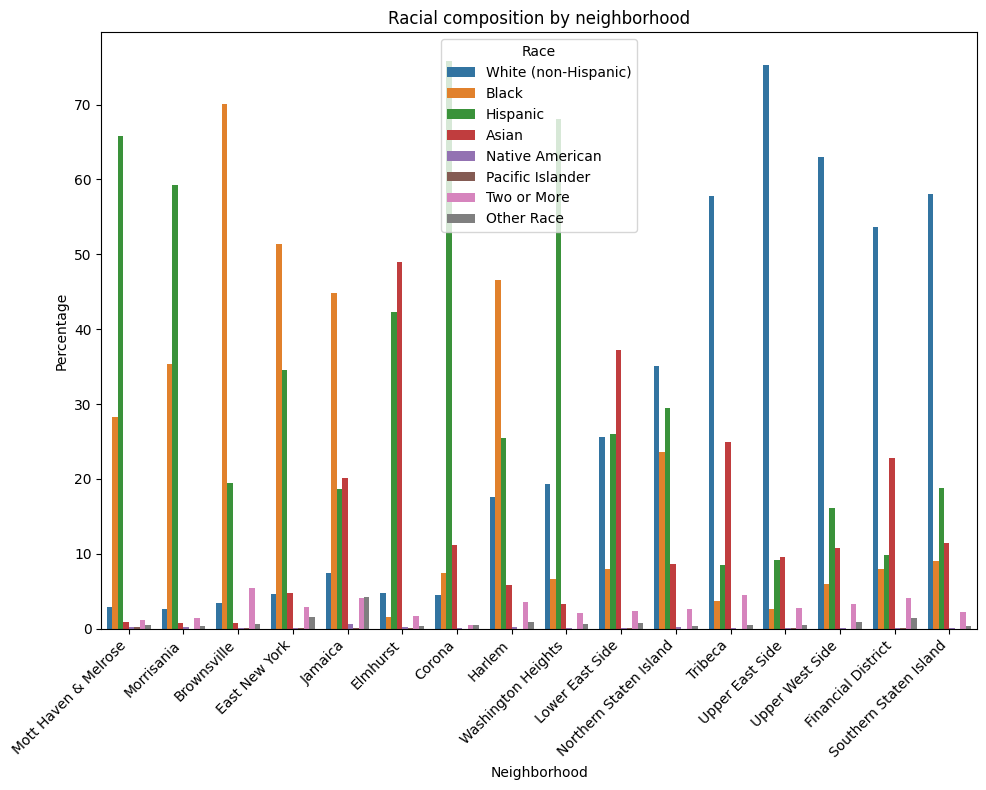

In [59]:
race_cols = ['White (non-Hispanic)','Black', 'Hispanic', 'Asian', 'Native American', 'Pacific Islander', 'Two or More', 'Other Race']
race_df = pd.melt(results_df,
                  id_vars=['Neighborhood'],
                  value_vars=race_cols,
                  var_name='Race',
                  value_name='Percentage')

plt.figure(figsize=(10, 8))
sns.barplot(x='Neighborhood', y='Percentage', hue='Race', data=race_df)
plt.xticks(rotation=45, ha='right')
plt.title('Racial composition by neighborhood')
plt.tight_layout()
plt.savefig('racial_composition.png')

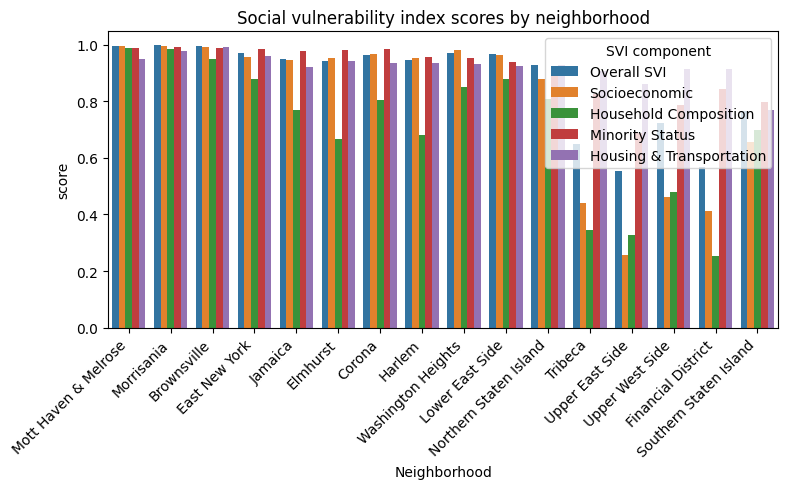

In [60]:
svi_cols = ['Overall SVI', 'Socioeconomic', 'Household Composition', 'Minority Status', 'Housing & Transportation']
nta_svi_df = pd.melt(results_df,
                 id_vars=['Neighborhood'],
                 value_vars=svi_cols,
                 var_name='SVI component',
                 value_name='score')

plt.figure(figsize=(8, 5))
sns.barplot(x='Neighborhood', y='score', hue='SVI component', data=nta_svi_df)
plt.xticks(rotation=45, ha='right')
plt.title('Social vulnerability index scores by neighborhood')
plt.tight_layout()

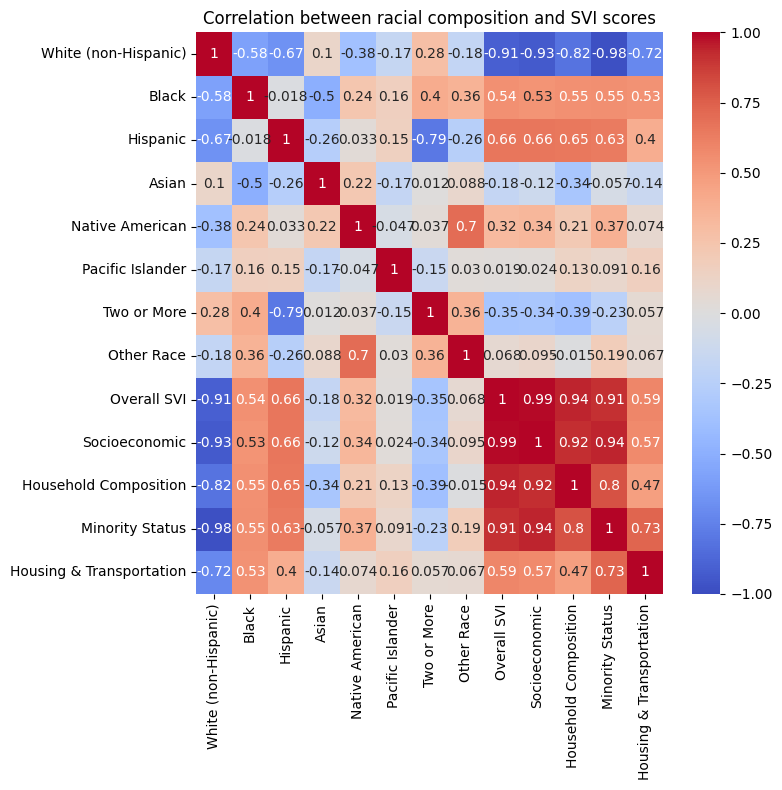

In [61]:
correlation_cols = race_cols + svi_cols
correlation_df = results_df[correlation_cols]
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between racial composition and SVI scores')
plt.tight_layout()

**This is not necessarily related to evictions**
What this heatmap shows is racial disparities in social vulnerability. White population demonstrates extremely strong negative correlations with all vulnerability measures (overall SVI: -0.96, minority status: -0.98, socioeconomic: -0.95, household somposition: -0.87, housing and transportation: -0.85). On the other hand, black and hispanic populations show significant positive correlations with SVI. Black population correlates positively with housing and transportation vulnerability (0.67) and moderately with other SVI measures (0.47-0.51), while Hispanic population shows strong positive correlations with household composition (0.60), overall SVI (0.58), and socioeconomic vulnerability (0.58). Asian population exhibits weak negative correlations with most vulnerability measures (overall: -0.14, house composition: -0.34). \


Strong inverse relationship between white population percentage and vulnerability scores across all SVI domains highlights profound systemic inequities in resource distribution, housing conditions, economic opportunities, and access to services throughout nyc neighborhoods.

In [28]:
svi_df_cleaned.shape

(204, 156)

In [29]:
svi_df_cleaned.columns

Index(['ST', 'STATE', 'ST_ABBR', 'FIPS', 'LOCATION', 'AREA_SQMI', 'E_TOTPOP',
       'M_TOTPOP', 'E_HU', 'M_HU',
       ...
       'EP_ASIAN', 'MP_ASIAN', 'EP_AIAN', 'MP_AIAN', 'EP_NHPI', 'MP_NHPI',
       'EP_TWOMORE', 'MP_TWOMORE', 'EP_OTHERRACE', 'MP_OTHERRACE'],
      dtype='object', length=156)

In [30]:
total_nan = svi_df_cleaned.isna().sum()
total_nan, \
total_nan.sum()
# no null values in the svi_df
# the null values come from merging

(ST              0
 STATE           0
 ST_ABBR         0
 FIPS            0
 LOCATION        0
                ..
 MP_NHPI         0
 EP_TWOMORE      0
 MP_TWOMORE      0
 EP_OTHERRACE    0
 MP_OTHERRACE    0
 Length: 156, dtype: int64,
 np.int64(0))

In [31]:
# make this change here to match with all other datasets that have already had their columns become lower case
svi_df_cleaned.columns = svi_df_cleaned.columns.str.lower()

In [32]:
svi_df_cleaned.columns.tolist()[:5]

['st', 'state', 'st_abbr', 'fips', 'location']

In [35]:
svi_df_cleaned.shape # 204 is actually the correct zipcode total of nyc.
# so many datasets simply can't have the complete zipcodes representation in them.

(204, 156)

In [39]:
svi_df_cleaned.isna().sum().sum()
# no null

np.int64(0)

In [40]:
svi_df_cleaned.duplicated().sum()
# no duplicates

np.int64(0)

In [45]:
svi_df_cleaned = svi_df_cleaned.drop(columns=['st', 'state', 'st_abbr'])

In [49]:
svi_df_cleaned.head()

,fips,location,area_sqmi,e_totpop,m_totpop,e_hu,m_hu,e_hh,m_hh,e_pov150,m_pov150,e_unemp,m_unemp,e_hburd,m_hburd,e_nohsdp,m_nohsdp,e_uninsur,m_uninsur,e_age65,m_age65,e_age17,m_age17,e_disabl,m_disabl,e_sngpnt,m_sngpnt,e_limeng,m_limeng,e_minrty,m_minrty,e_munit,m_munit,e_mobile,m_mobile,e_crowd,m_crowd,e_noveh,m_noveh,e_groupq,m_groupq,ep_pov150,mp_pov150,ep_unemp,mp_unemp,ep_hburd,mp_hburd,ep_nohsdp,mp_nohsdp,ep_uninsur,mp_uninsur,ep_age65,mp_age65,ep_age17,mp_age17,ep_disabl,mp_disabl,ep_sngpnt,mp_sngpnt,ep_limeng,mp_limeng,ep_minrty,mp_minrty,ep_munit,mp_munit,ep_mobile,mp_mobile,ep_crowd,mp_crowd,ep_noveh,mp_noveh,ep_groupq,mp_groupq,epl_pov150,epl_unemp,epl_hburd,epl_nohsdp,epl_uninsur,spl_theme1,rpl_theme1,epl_age65,epl_age17,epl_disabl,epl_sngpnt,epl_limeng,spl_theme2,rpl_theme2,epl_minrty,spl_theme3,rpl_theme3,epl_munit,epl_mobile,epl_crowd,epl_noveh,epl_groupq,spl_theme4,rpl_theme4,spl_themes,rpl_themes,f_pov150,f_unemp,f_hburd,f_nohsdp,f_uninsur,f_theme1,f_age65,f_age17,f_disabl,f_sngpnt,f_limeng,f_theme2,f_minrty,f_theme3,f_munit,f_mobile,f_crowd,f_noveh,f_groupq,f_theme4,f_total,e_daypop,e_noint,m_noint,e_afam,m_afam,e_hisp,m_hisp,e_asian,m_asian,e_aian,m_aian,e_nhpi,m_nhpi,e_twomore,m_twomore,e_otherrace,m_otherrace,ep_noint,mp_noint,ep_afam,mp_afam,ep_hisp,mp_hisp,ep_asian,mp_asian,ep_aian,mp_aian,ep_nhpi,mp_nhpi,ep_twomore,mp_twomore,ep_otherrace,mp_otherrace
1,10001,ZCTA5 10001,0.623822,27004,1827,16975,831,14375,782,5248,797,761,266,3314,531,1930,534,831,289,3428,432,2694,643,2310,499,501,215,1381,405,13460,2305,15840,898,15,23,389,135,12285,840,2213,218,20.3,2.7,4.3,1.5,23.1,3.5,9.1,2.4,3.1,1.0,12.7,1.6,10.0,2.1,8.6,1.9,3.5,1.5,5.3,1.5,49.8,7.8,93.3,2.7,0.1,0.1,2.7,0.9,85.5,2.8,8.2,0.6,0.6108,0.4574,0.5573,0.5902,0.4436,2.6593,0.5688,0.1420,0.1161,0.1891,0.4707,0.8777,1.7956,0.1692,0.8670,0.8670,0.8670,0.9853,0.271,0.7402,0.9949,0.9104,3.9018,0.9806,9.2237,0.7414,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,3,3,239407,1047,389,2220,576,5206,943,5031,774,0,25,0,25,780,326,223,169,7.3,2.6,8.2,2.2,19.3,3.0,18.6,2.9,0.0,0.1,0.0,0.1,2.9,1.2,0.8,0.6
2,10002,ZCTA5 10002,0.822292,76518,2894,39094,1241,36028,1326,27908,2853,2833,574,14688,1367,18301,1376,4074,766,17681,1287,10028,1549,9896,1062,2211,499,18393,1640,56964,3226,35725,1677,16,28,2461,449,29828,1403,2090,39,36.8,3.5,7.6,1.4,40.8,3.5,30.0,2.0,5.4,1.0,23.1,1.7,13.1,1.8,13.0,1.4,6.1,1.4,24.7,2.0,74.4,3.1,91.4,3.2,0.0,0.1,6.8,1.2,82.8,1.8,2.7,0.1,0.9148,0.7946,0.9219,0.9741,0.7207,4.3261,0.9639,0.7296,0.1831,0.5186,0.7390,0.9944,3.1647,0.8781,0.9369,0.9369,0.9369,0.9790,0.000,0.9105,0.9915,0.7730,3.6540,0.9254,12.0817,0.9656,1,0,1,1,0,3,0,0,0,0,1,1,1,1,1,0,1,1,0,3,8,64307,8590,1110,6141,1194,19864,2190,28477,1989,74,83,24,45,1810,486,574,394,23.8,2.9,8.0,1.5,26.0,2.5,37.2,2.2,0.1,0.1,0.0,0.1,2.4,0.6,0.8,0.5
3,10003,ZCTA5 10003,0.571603,53877,2579,30766,956,24987,936,6397,1171,1613,315,5445,853,1574,422,1282,404,8128,792,3866,718,3604,634,278,171,1217,828,19778,3548,27261,1299,0,31,798,282,20035,905,10199,194,14.3,2.5,4.7,0.9,21.8,3.3,4.2,1.2,2.4,0.7,15.1,1.4,7.2,1.2,6.7,1.2,1.1,0.7,2.3,1.6,36.7,6.3,88.6,3.2,0.0,0.1,3.2,1.1,80.2,2.8,18.9,1.0,0.4017,0.5142,0.4934,0.2486,0.3386,1.9965,0.3389,0.2513,0.0851,0.0965,0.2217,0.7589,1.4135,0.0969,0.7977,0.7977,0.7977,0.9745,0.000,0.7852,0.9869,0.9577,3.7043,0.9368,7.9120,0.5373,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,3,3,138011,1458,478,2899,748,5541,943,9014,1065,51,52,27,32,2067,547,179,132,5.8,1.8,5.4,1.4,10.3,1.7,16.7,1.9,0.1,0.1,0.1,0.1,3.8,1.0,0.3,0.2
4,10004,ZCTA5 10004,0.455576,4579,926,2706,484,2123,394,169,101,11,16,130,84,32,28,13,19,190,131,840,341,104,82,8,16,39,73,2009,1102,2592,476,0,13,161,99,1548,318,35,13,3.7,2.1,0.4,0.5,6.1,3.8,0.9,0.8,0.3,0.4,4.1,2.9,18.3,5.1,2.3,1.9,0.4,0.7,0.9,1.8,43.9,22.4,95.8,4.0,0.0,1.5,7.6,4.4,72.9,9.4,0.8,0.2,0.0699,0.1413,0.0570,0.0834,0.1213,0.4729,0.0252,0.0400,0.3921,0.0412,0.1846,0.5977,1.2556,0.0769,0.8439,0.8439,0.8439,0.9898,0.000,0.9254,0.9749,0.5510,3.4411,0.8558,6.0135,0.2

In [46]:
svi_df_cleaned.to_csv('/content/drive/My Drive/X999/svi_cleaned.csv', index=False)

In [34]:
summary_cols = ['Neighborhood', 'Population', 'Overall SVI', 'Poverty Rate (%)',
                'Unemployment (%)', 'No High School Diploma (%)', 'Uninsured (%)']
summary_table = results_df[summary_cols].sort_values('Overall SVI', ascending=False)
summary_table

,Neighborhood,Population,Overall SVI,Poverty Rate (%),Unemployment (%),No High School Diploma (%),Uninsured (%)
1,Morrisania,219703,0.996953,48.941707,12.940613,31.015226,8.008425
0,Mott Haven & Melrose,136764,0.995195,50.684675,11.704815,32.611518,8.622205
2,Brownsville,84006,0.994800,45.300000,14.200000,23.800000,7.300000
3,East New York,221789,0.971361,33.026303,8.580173,17.992746,5.532074
8,Washington Heights,204414,0.970784,28.740025,12.148274,23.582875,8.252459
9,Lower East Side,76518,0.965600,36.800000,7.600000,30.000000,5.400000
6,Corona,112750,0.963300,29.500000,5.300000,35.600000,23.400000
4,Jamaica,252625,0.949985,22.022780,10.251442,17.673503,8.100223
7,Harlem,184364,0.946491,34.268691,10.647248,14.879316,6.186660
5,Elmhurst,102618,0.943200,23.800000,5.500000,25.400000,15.500000
